<a href="https://colab.research.google.com/github/maxi2321/MAXIABDALA/blob/main/Copia_de_final8_0(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
datatrain = '/content/drive/MyDrive/train_ant4'
dataval = '/content/drive/MyDrive/val'

In [4]:
# Verificar si CUDA está disponible y configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## LECTURA DE DATOS

In [5]:
# vemos los archivos de audio
# carpeta del training set
classes_folders1 = os.listdir(datatrain)                   # carpeta de cada clase

# Creamos un diccionario para cada clase donde pondremos los audios
data_train = {}
for c in classes_folders1:
    if c[0] != '.':
        data_train[c] = data_train.get(c, []) # agregamos

# Llenamos una lista para cada clase con los datos
b=0
for c in classes_folders1:
    if c[0] != '.':
        for f in os.listdir(os.path.join(datatrain, c)):
            path = os.path.join(datatrain, c, f)
            audio, sr = librosa.load(os.path.join(datatrain, c, f) , sr=None)  # leemos el audio como numpy array
            duracion = librosa.get_duration(y=audio, sr=sr)
            if (b):
              if (duracion<men): men=duracion
            else:
              men=duracion
              b=1
            data_train[c].append(audio)   # no guardamos el samplerate porque todos son iguales

# Inspección de los datos

for k in data_train.keys():
    print(f'La clase {k} tiene {len(data_train[k])} elementos')

classes_folders2 = os.listdir(dataval)
# Creamos un diccionario para cada clase donde pondremos los audios
data_val = {}
for c in classes_folders2:
    if c[0] != '.':
        data_val[c] = data_val.get(c, []) # agregamos

# Llenamos una lista para cada clase con los datos
b=0
for c in classes_folders2:
    if c[0] != '.':
        for f in os.listdir(os.path.join(dataval, c)):
            path = os.path.join(dataval, c, f)
            audio, sr = librosa.load(os.path.join(dataval, c, f) , sr=None)  # leemos el audio como numpy array
            duracion = librosa.get_duration(y=audio, sr=sr)
            if (b):
              if (duracion<men): men=duracion
            else:
              men=duracion
              b=1
            data_val[c].append(audio)   # no guardamos el samplerate porque todos son iguales

# Inspección de los datos

for k in data_val.keys():
    print(f'La clase {k} tiene {len(data_val[k])} elementos')

La clase colectivo tiene 20 elementos
La clase camioneta tiene 12 elementos
La clase auto tiene 16 elementos
La clase silencio tiene 30 elementos
La clase moto tiene 12 elementos
La clase auto tiene 5 elementos
La clase silencio tiene 4 elementos
La clase colectivo tiene 3 elementos
La clase camioneta tiene 5 elementos
La clase moto tiene 4 elementos


In [6]:
print(sr)

22050


## ESPECTOGRAMAS CON STFT

Clase colectivo (train): 20 espectrogramas STFT
Clase camioneta (train): 12 espectrogramas STFT
Clase auto (train): 16 espectrogramas STFT
Clase silencio (train): 30 espectrogramas STFT
Clase moto (train): 12 espectrogramas STFT
Clase auto (val): 5 espectrogramas STFT
Clase silencio (val): 4 espectrogramas STFT
Clase colectivo (val): 3 espectrogramas STFT
Clase camioneta (val): 5 espectrogramas STFT
Clase moto (val): 4 espectrogramas STFT


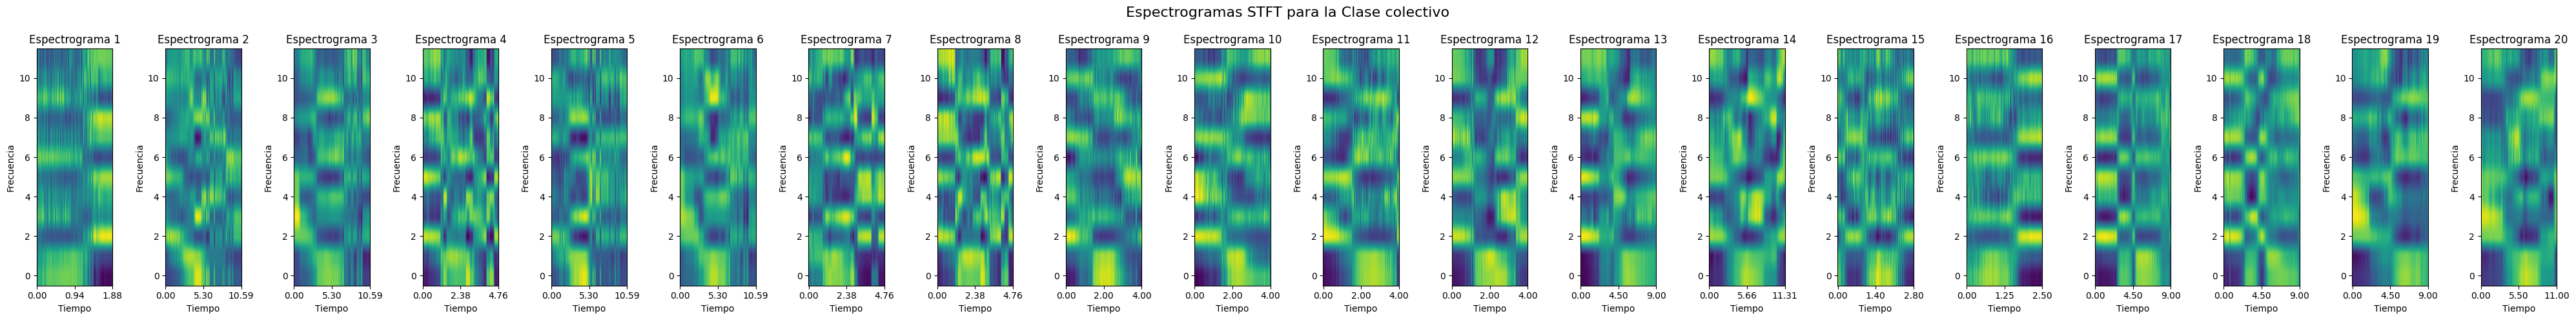

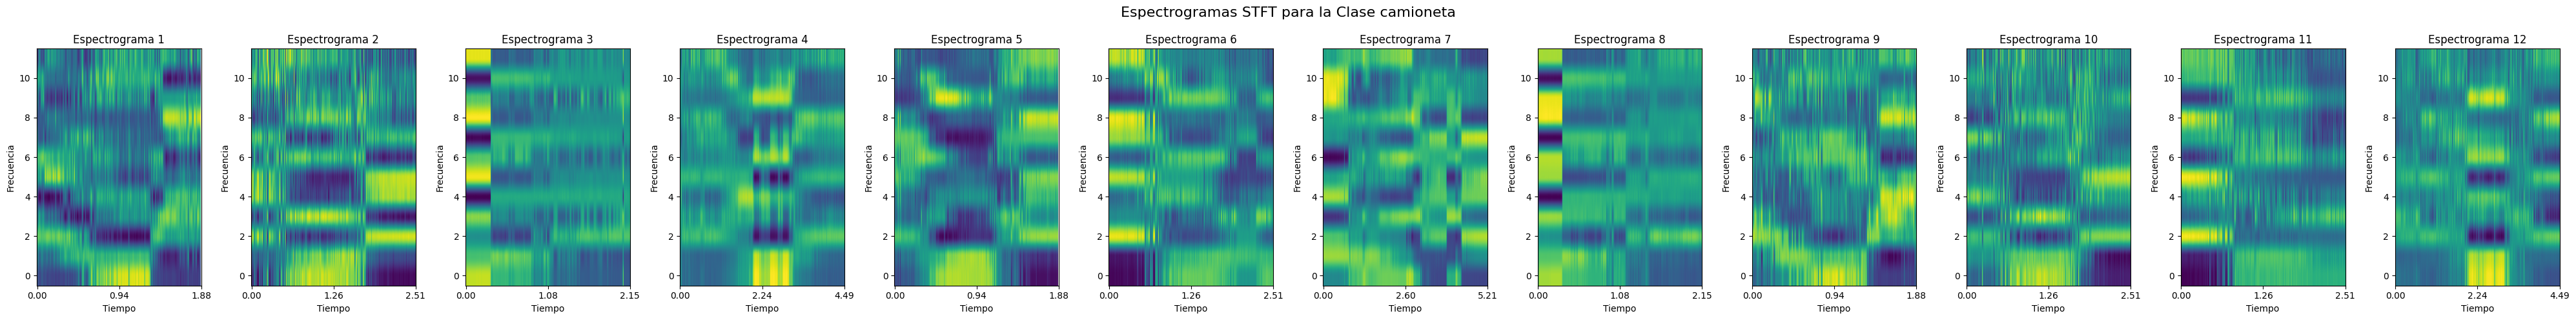

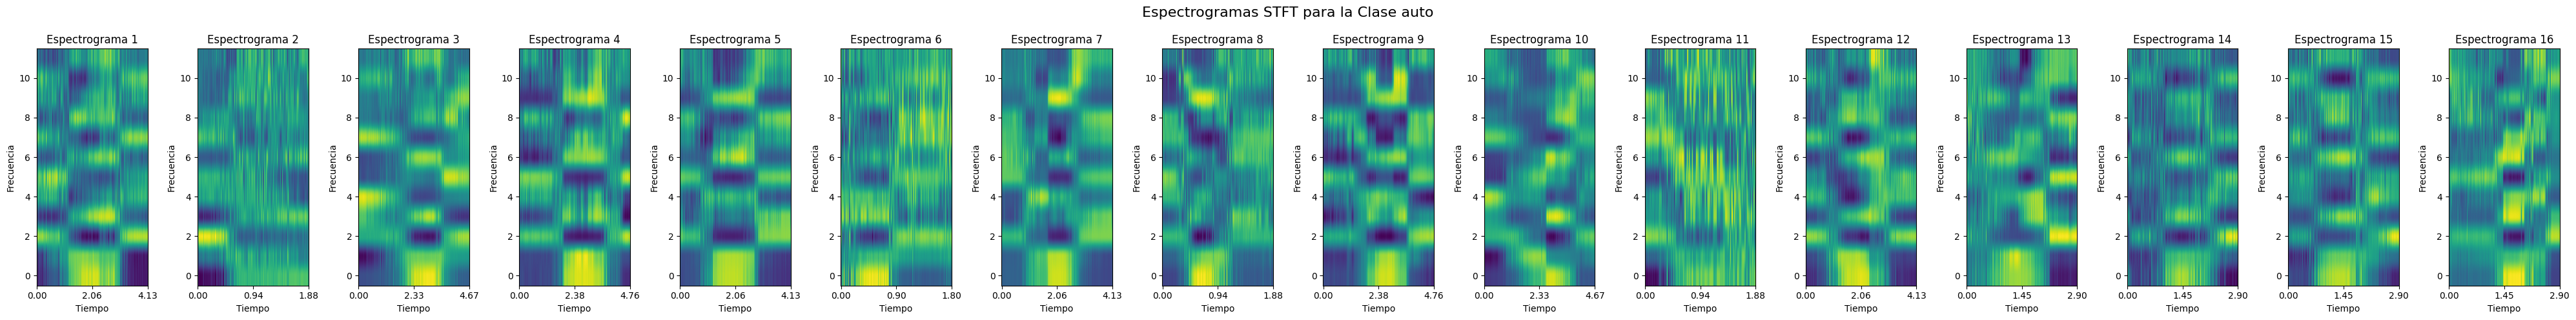

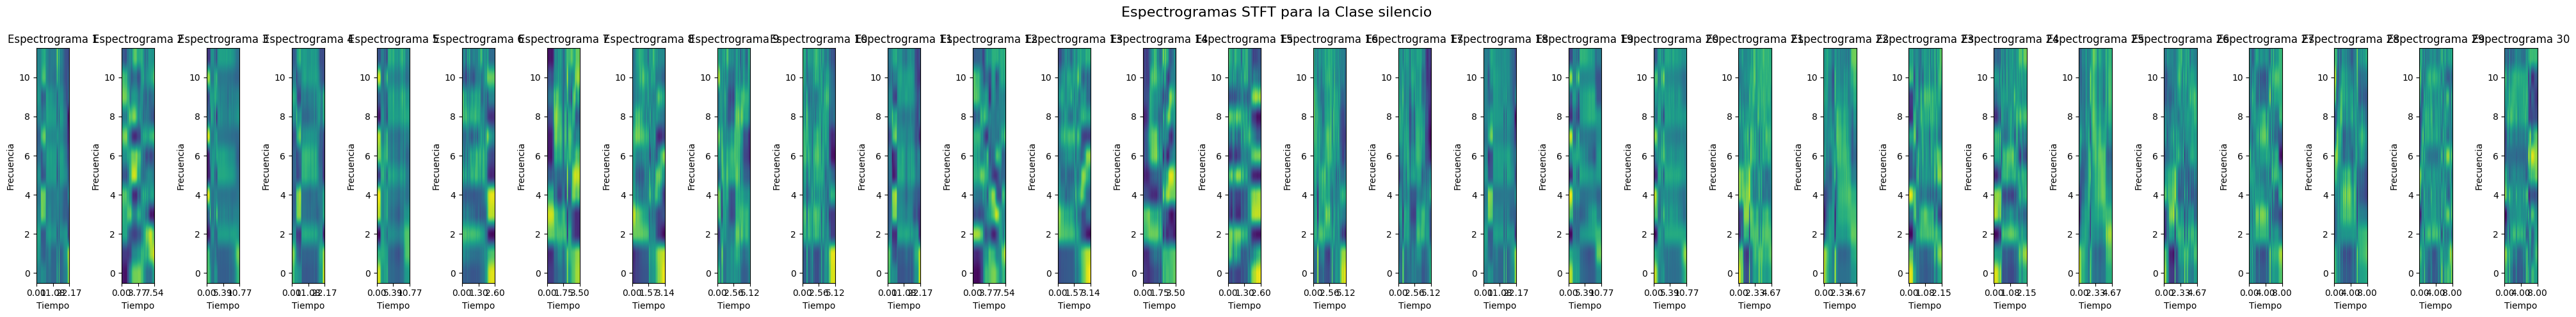

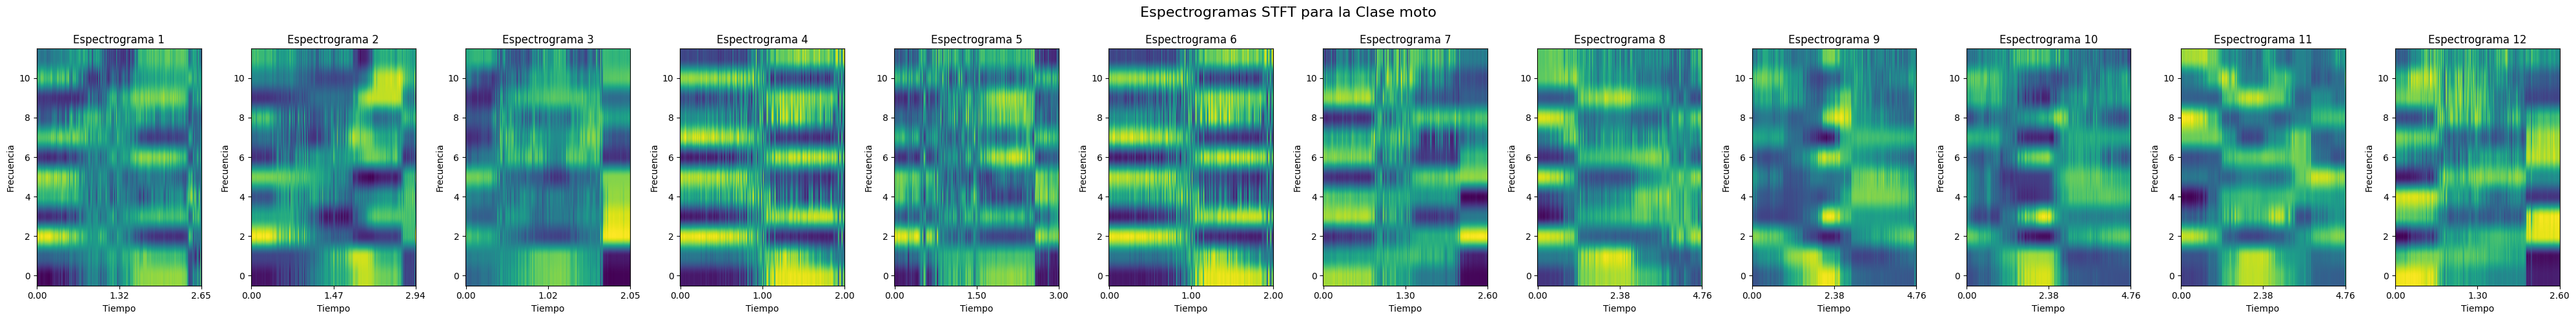

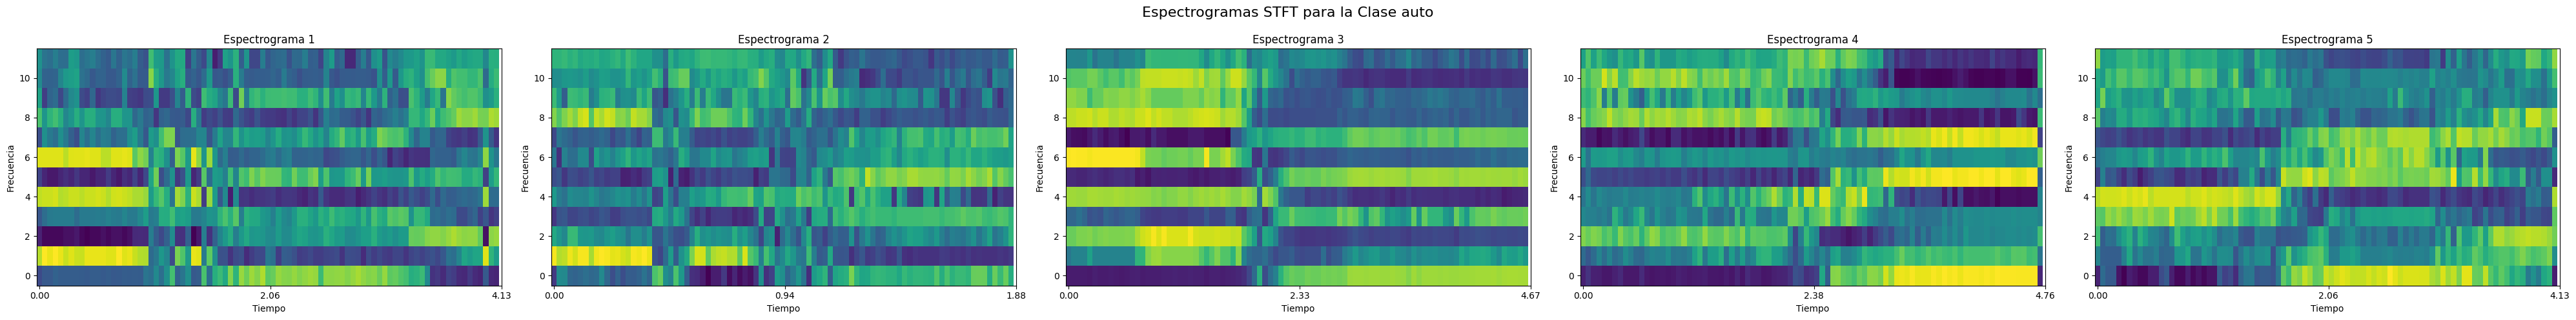

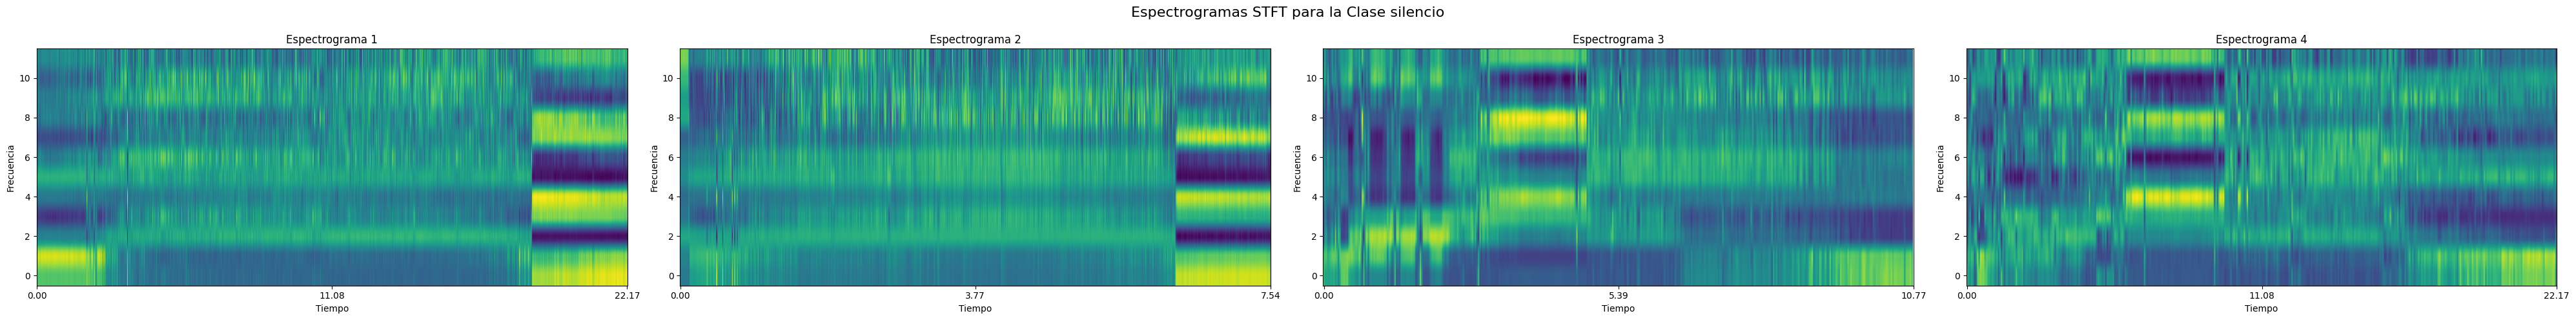

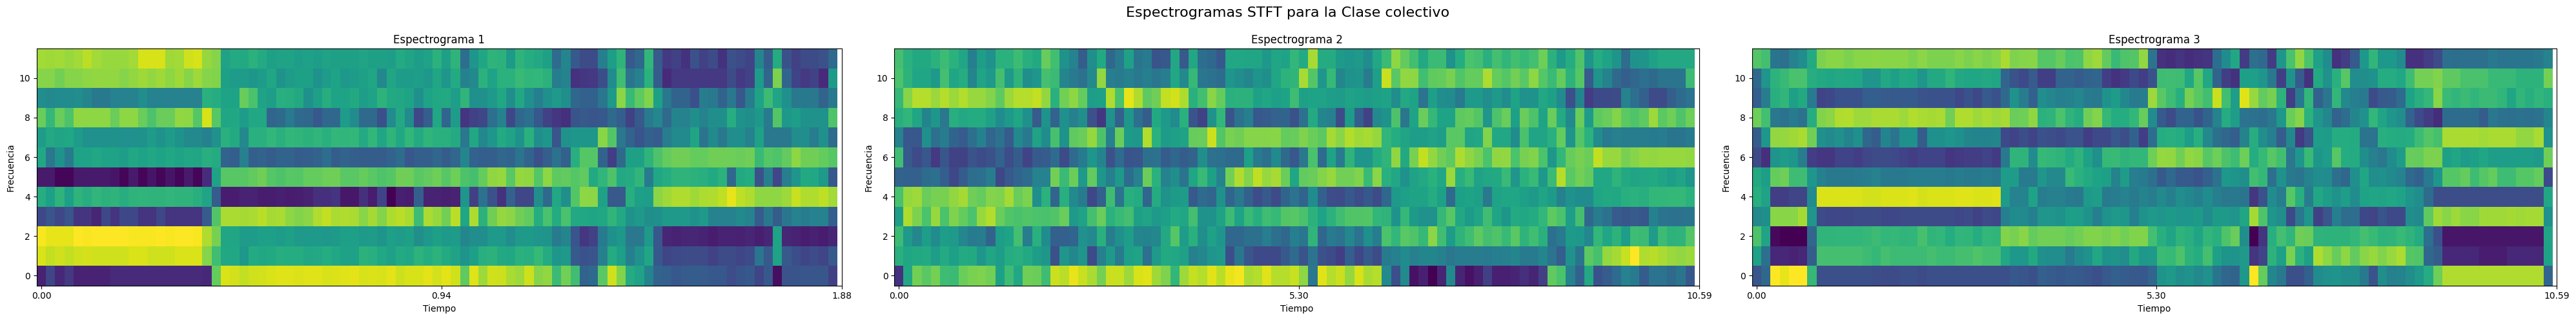

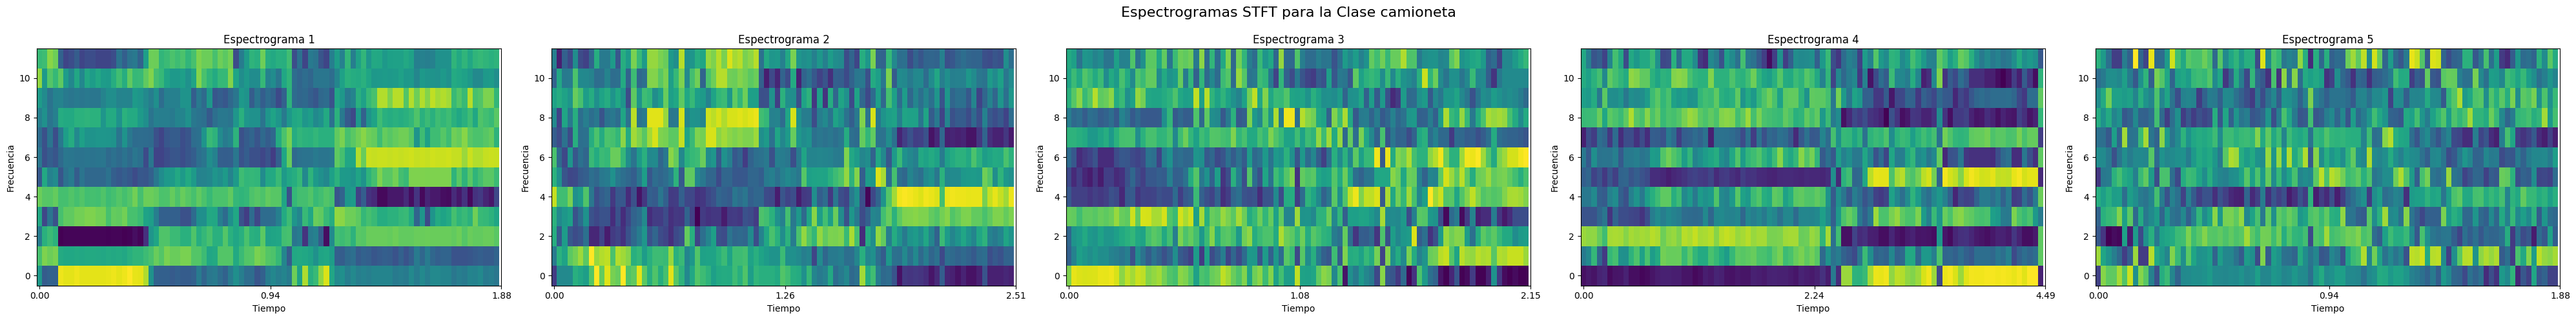

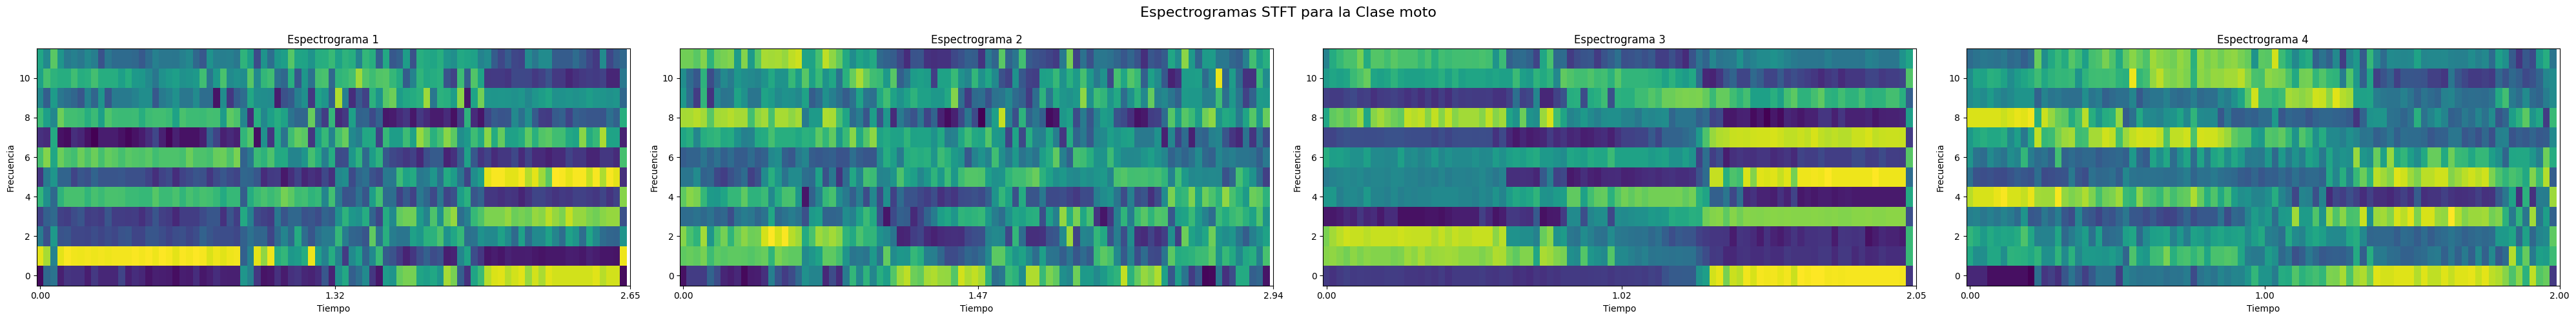

In [7]:

# Tasa de muestreo que vamos a asumir para todos los audios
sampling_rate = 48000
n_fft=1024
hop_length=512
n_mfcc=12

def compute_mfcc_spectrogram(audio_array, sampling_rate, n_fft, hop_length, n_mfcc):
    """
    Computar los coeficientes MFCC para un array de audio dado y normalizar el espectrograma.

    Args:
    - audio_array (np.ndarray): Array que contiene datos de audio.
    - sampling_rate (int): Frecuencia de muestreo del archivo de audio.
    - n_fft (int): Longitud de la ventana FFT.
    - hop_length (int): Número de muestras entre fotogramas sucesivos.
    - n_mfcc (int): Número de MFCCs a devolver.

    Returns:
    - mfccs_smoothed (np.ndarray): Representación MFCC normalizada y suavizada del audio.
    """
    # Computar la STFT
    stft = librosa.stft(audio_array, n_fft=n_fft, hop_length=hop_length)
    stft_db = librosa.amplitude_to_db(abs(stft))

    # Computar los MFCCs
    mfccs = librosa.feature.mfcc(S=stft_db, sr=sampling_rate, n_mfcc=n_mfcc)

    # Normalizar los MFCCs
    mfccs_norm = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / (np.std(mfccs, axis=1, keepdims=True) + 1e-6)

    # Aplicar un filtro de suavizado a los MFCCs para resaltar las características
    mfccs_smoothed = librosa.decompose.nn_filter(mfccs_norm, aggregate=np.median, metric='cosine')

    return mfccs_smoothed

def plot_stft_spectrograms(stft_spectrograms, class_name, sr):
    num_specs = len(stft_spectrograms[class_name])
    fig, axs = plt.subplots(1, num_specs, figsize=(40, 5))
    fig.suptitle(f'Espectrogramas STFT para la Clase {class_name}', fontsize=16)

    for i, stft_spec in enumerate(stft_spectrograms[class_name]):
        img = axs[i].imshow(stft_spec, cmap='viridis', origin='lower', aspect='auto')
        axs[i].set_title(f'Espectrograma {i + 1}')
        axs[i].set_xlabel('Tiempo')
        axs[i].set_ylabel('Frecuencia')

        # Calcular marcas de tiempo
        num_time_bins = stft_spec.shape[1]
        duration = len(data_train[class_name][i]) / sr
        time_ticks = np.linspace(0, duration, num_time_bins)

        # Configurar las marcas de tiempo en el eje x
        axs[i].set_xticks(np.linspace(0, num_time_bins, 3))
        axs[i].set_xticklabels([f'{t:.2f}' for t in np.linspace(0, duration, 3)])

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Ajustar el espacio para el título
    plt.show()


# Procesar data_train
stft_spectrograms_train = {}

for k, v in data_train.items():
    stft_spectrograms_train[k] = []
    for audio_array in v:
        stft_spec = compute_mfcc_spectrogram(audio_array, sampling_rate, n_fft, hop_length, n_mfcc)
        stft_spectrograms_train[k].append(stft_spec)

# Verificar la cantidad de espectrogramas calculados por clase
for k, v in stft_spectrograms_train.items():
    print(f'Clase {k} (train): {len(v)} espectrogramas STFT')

# Procesar data_val
stft_spectrograms_val = {}

for k, v in data_val.items():
    stft_spectrograms_val[k] = []
    for audio_array in v:
        stft_spec = compute_mfcc_spectrogram(audio_array, sampling_rate, n_fft, hop_length, n_mfcc)
        stft_spectrograms_val[k].append(stft_spec)

# Verificar la cantidad de espectrogramas calculados por clase
for k, v in stft_spectrograms_val.items():
    print(f'Clase {k} (val): {len(v)} espectrogramas STFT')

# Graficar los espectrogramas STFT para cada clase en data_train
for class_name in stft_spectrograms_train.keys():
    plot_stft_spectrograms(stft_spectrograms_train, class_name, sampling_rate)

# Graficar los espectrogramas STFT para cada clase en data_val
for class_name in stft_spectrograms_val.keys():
    plot_stft_spectrograms(stft_spectrograms_val, class_name, sampling_rate)


##Resumen
#Computar MFCCs: Calcula los coeficientes MFCC del audio.
#Normalizar MFCCs: Resta la media y divide por la desviación estándar para que los datos tengan una distribución más uniforme.
#Suavizar MFCCs: Aplica un filtro de vecinos más cercanos para resaltar las características importantes y reducir el ruido.
#Devolver MFCCs: Devuelve los MFCCs suavizados y normalizados.
Este proceso ayuda a transformar los datos de audio en una representación que es más fácil de analizar y procesar para tareas de reconocimiento y clasificación.


In [8]:
# Calcular y mostrar las dimensiones de los espectrogramas en stft_spectrograms_train
for class_name, spectrogram_list in stft_spectrograms_train.items():
    for idx, spectrogram in enumerate(spectrogram_list):
        print(f'Dimensiones del espectrograma para la clase {class_name} (train), índice {idx}: {spectrogram.shape}')

# Calcular y mostrar las dimensiones de los espectrogramas en stft_spectrograms_val
for class_name, spectrogram_list in stft_spectrograms_val.items():
    for idx, spectrogram in enumerate(spectrogram_list):
        print(f'Dimensiones del espectrograma para la clase {class_name} (val), índice {idx}: {spectrogram.shape}')


Dimensiones del espectrograma para la clase colectivo (train), índice 0: (12, 177)
Dimensiones del espectrograma para la clase colectivo (train), índice 1: (12, 993)
Dimensiones del espectrograma para la clase colectivo (train), índice 2: (12, 993)
Dimensiones del espectrograma para la clase colectivo (train), índice 3: (12, 446)
Dimensiones del espectrograma para la clase colectivo (train), índice 4: (12, 993)
Dimensiones del espectrograma para la clase colectivo (train), índice 5: (12, 993)
Dimensiones del espectrograma para la clase colectivo (train), índice 6: (12, 446)
Dimensiones del espectrograma para la clase colectivo (train), índice 7: (12, 446)
Dimensiones del espectrograma para la clase colectivo (train), índice 8: (12, 376)
Dimensiones del espectrograma para la clase colectivo (train), índice 9: (12, 376)
Dimensiones del espectrograma para la clase colectivo (train), índice 10: (12, 376)
Dimensiones del espectrograma para la clase colectivo (train), índice 11: (12, 376)
Di

# PASAMOS LOS ESPECTOGRAMAS A TENSORES PARA ARMAR EL DATASET

In [9]:
# Definir la longitud deseada para los espectrogramas
men = 2074  # Ajusta la longitud según sea necesario

# Función para convertir espectrogramas a tensores de PyTorch
def convert_to_tensors(stft_spectrograms, men):
    mel_tensor_list = []
    labels_list = []

    for label, mel_specs in stft_spectrograms.items():
        for mel_spec in mel_specs:
            # Asegurarse de que todos los espectrogramas tengan la misma forma (128, men)
            if mel_spec.shape[1] > men:
                mel_spec = mel_spec[:, :men]  # Recortar si es más largo
            elif mel_spec.shape[1] < men:
                mel_spec = np.pad(mel_spec, ((0, 0), (0, men - mel_spec.shape[1])), mode='constant')  # Rellenar si es más corto

            mel_tensor = torch.tensor(mel_spec).unsqueeze(0).float()  # Convertir y añadir dimensión de canal
            mel_tensor_list.append(mel_tensor)
            labels_list.append(label)

    labels_tensor = torch.tensor([list(stft_spectrograms.keys()).index(label) for label in labels_list])
    dataset = TensorDataset(torch.stack(mel_tensor_list), labels_tensor)

    return dataset, labels_tensor

# Convertir los espectrogramas de Mel a tensores de PyTorch para cada conjunto de datos
train_dataset, train_labels = convert_to_tensors(stft_spectrograms_train, men)
val_dataset, val_labels = convert_to_tensors(stft_spectrograms_val, men)

# Verificar las dimensiones de los tensores y los labels
print(f'Tamaño del dataset de entrenamiento: {len(train_dataset)}')
print(train_labels)
print(f'Tamaño del dataset de validación: {len(val_dataset)}')
print(val_labels)


Tamaño del dataset de entrenamiento: 90
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])
Tamaño del dataset de validación: 21
tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4])


## COMPROBAMOS LAS DIMENSIONES DE LA IMAGEN

In [10]:
# Acceder a un solo elemento del dataset (por ejemplo, el primer elemento)
sample_image, sample_label = val_dataset[0]

# Inspeccionar las dimensiones del tensor de la imagen
print("Dimensiones de la imagen:", sample_image.size())

# Inspeccionar las dimensiones del tensor de etiquetas
print("Dimensiones de la etiqueta:", sample_label)

Dimensiones de la imagen: torch.Size([1, 12, 2074])
Dimensiones de la etiqueta: tensor(0)


## SEPARAMOS EN TRAIN Y VAL

In [11]:
# Convertir los espectrogramas de Mel a tensores de PyTorch para cada conjunto de datos
train_dataset, train_labels = convert_to_tensors(stft_spectrograms_train, men)
val_dataset, val_labels = convert_to_tensors(stft_spectrograms_val, men)

# Verificar las dimensiones de los tensores
print(f'Tamaño del dataset de entrenamiento: {len(train_dataset)}')
print(f'Tamaño del dataset de validación: {len(val_dataset)}')
print(f'Tamaño del conjunto de etiquetas de entrenamiento: {len(train_labels)}')
print(f'Tamaño del conjunto de etiquetas de validación: {len(val_labels)}')


Tamaño del dataset de entrenamiento: 90
Tamaño del dataset de validación: 21
Tamaño del conjunto de etiquetas de entrenamiento: 90
Tamaño del conjunto de etiquetas de validación: 21



## DATALOADERS

In [12]:
from torch.utils.data import DataLoader

# Crear DataLoader para el conjunto de entrenamiento con batch size de 32
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

# Crear DataLoader para el conjunto de validación con batch size de 32
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Opcionalmente, puedes imprimir el tamaño de cada DataLoader para verificar
print(f'Tamaño del DataLoader de entrenamiento: {len(train_loader)}')
print(f'Tamaño del DataLoader de validación: {len(val_loader)}')


Tamaño del DataLoader de entrenamiento: 2
Tamaño del DataLoader de validación: 2


## MODELO

In [13]:
import torch
import torch.nn as nn

# Definición del modelo
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Salida de conv1: [1, 16, 40, 354] (16 canales, cada uno de tamaño 40x354)

        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Salida de maxpool1: [1, 16, 20, 177] (tamaño reducido a la mitad en ambas dimensiones)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Salida de conv2: [1, 32, 20, 177] (32 canales, cada uno de tamaño 20x177)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Salida de maxpool2: [1, 32, 10, 88] (tamaño reducido a la mitad en ambas dimensiones)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Salida de conv3: [1, 64, 10, 88] (64 canales, cada uno de tamaño 10x88)

        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Salida de maxpool3: [1, 64, 5, 44] (tamaño reducido a la mitad en ambas dimensiones)

        self.dropout = nn.Dropout(p=0.5)

        # LSTM como codificador
        self.input_size = 64 * (12 // 8) * (2074 // 8)  # Ajustar según las dimensiones de entrada
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=128,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)

        # Salida de LSTM: [1, 256] (128 unidades ocultas bidireccionales, ya que es LSTM bidireccional)

        # Decoder
        self.fc1 = nn.Linear(2 * 128, 128)
        # Salida de fc1: [1, 128] (128 neuronas)

        self.fc2 = nn.Linear(128, 64)
        # Salida de fc2: [1, 64] (64 neuronas)

        self.fc3 = nn.Linear(64, num_classes)  # Cambiar el tamaño de salida a num_classes
        # Salida de fc3: [1, num_classes] (num_classes neuronas, donde num_classes es el número de categorías)

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool3(x)
        x = self.dropout(x)

        # Preparar para LSTM
        x = x.view(x.size(0), -1)
        x = x.unsqueeze(1)

        # LSTM como codificador
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]

        # Decoder
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x


modelo SimpleCNN en una estructura de Autoencoder, donde las dimensiones se van achicando y luego se van expandiendo, puedes seguir este enfoque:

Encoder:

Utilizarás las capas convolucionales (conv1, conv2, conv3) para reducir progresivamente las dimensiones de entrada.
No necesitarás las capas completamente conectadas (fc1, fc2, fc3) en el encoder, ya que el autoencoder se basa en la representación latente aprendida por las capas convolucionales.
Decoder:

Después de la capa LSTM en tu modelo actual, necesitarás una serie de capas deconvolucionales (también conocidas como capas transpuestas convolucionales) para reconstruir la entrada original a partir de la representación latente generada por el LSTM.
Estas capas deconvolucionales expandirán progresivamente las dimensiones de la entrada latente.
Aquí tienes una versión modificada de tu modelo SimpleCNN

## INSTANCIAMOS EL MODELO

In [14]:
# Definir hiperparámetros
learning_rate = 0.001 # no es necesario con adadelta
num_epochs = 100

# Crear una instancia del modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=5).to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), learning_rate)
optimizer = optim.Adadelta(model.parameters())

## FUNCION DE ENTRENAMIENTO

In [15]:
# Función de entrenamiento
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        # Modo de entrenamiento
        model.train()
        train_loss = 0.0
        correct_train_preds = 0
        total_train_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Ajustar las dimensiones de las etiquetas
            labels = labels.squeeze().long()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            # Calcular precisión de entrenamiento
            _, predicted = torch.max(outputs, 1)
            correct_train_preds += (predicted == labels).sum().item()
            total_train_preds += labels.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = correct_train_preds / total_train_preds

        # Modo de evaluación
        model.eval()
        val_loss = 0.0
        correct_val_preds = 0
        total_val_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                # Ajustar las dimensiones de las etiquetas
                labels = labels.squeeze().long()

                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Calcular precisión de validación
                _, predicted = torch.max(outputs, 1)
                correct_val_preds += (predicted == labels).sum().item()
                total_val_preds += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val_preds / total_val_preds
        val_accuracies.append(val_accuracy)

        # Imprimir métricas del epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Graficar las curvas de pérdida y precisión en validación
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(np.arange(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, val_accuracies


## ENTRENAMIENTO

In [ ]:
# Entrenar el modelo
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/100], Train Loss: 1.6217, Train Acc: 0.1667, Val Loss: 1.6154, Val Acc: 0.1429
Epoch [2/100], Train Loss: 1.6110, Train Acc: 0.2444, Val Loss: 1.6147, Val Acc: 0.1429
Epoch [3/100], Train Loss: 1.5996, Train Acc: 0.2333, Val Loss: 1.6156, Val Acc: 0.2381
Epoch [4/100], Train Loss: 1.6011, Train Acc: 0.3000, Val Loss: 1.6160, Val Acc: 0.2381
Epoch [5/100], Train Loss: 1.5785, Train Acc: 0.3111, Val Loss: 1.6188, Val Acc: 0.2381
Epoch [6/100], Train Loss: 1.5548, Train Acc: 0.3444, Val Loss: 1.6240, Val Acc: 0.2381
Epoch [7/100], Train Loss: 1.5184, Train Acc: 0.3444, Val Loss: 1.6482, Val Acc: 0.2381
Epoch [8/100], Train Loss: 1.5589, Train Acc: 0.3111, Val Loss: 1.6267, Val Acc: 0.2381
Epoch [9/100], Train Loss: 1.5369, Train Acc: 0.3444, Val Loss: 1.6333, Val Acc: 0.2381
Epoch [10/100], Train Loss: 1.5112, Train Acc: 0.3556, Val Loss: 1.6357, Val Acc: 0.2381
Epoch [11/100], Train Loss: 1.4939, Train Acc: 0.3222, Val Loss: 1.6473, Val Acc: 0.2381


## PREDICCION

In [ ]:
import random

# Función para hacer una predicción aleatoria en el conjunto de validación
def predict_random_sample(model, val_loader):
    model.eval()
    model = model.to(device)

    # Seleccionar un índice aleatorio del conjunto de validación
    random_idx = random.randint(0, len(val_loader.dataset) - 1)
    random_sample = val_loader.dataset[random_idx]

    # Obtener las entradas y etiquetas del lote
    inputs, label = random_sample

    # Si es necesario, ajustar la forma de las entradas para que se ajuste al modelo
    inputs = inputs.unsqueeze(0)  # Añadir una dimensión de lote

    # Mover las entradas a la GPU si está disponible
    inputs = inputs.to(device)

    # Hacer la predicción
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    # Imprimir la etiqueta verdadera y la predicción
    print(f'Etiqueta verdadera: {label.item()}, Predicción: {predicted.item()}')
    print(f'tensor:{outputs}')

In [ ]:
predict_random_sample(model, val_loader)
